# A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems
This is the code for the paper entitled "**A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems**" accepted in *IEEE Transactions on Industrial Informatics* (IF: 11.648).  <br>
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  <br>
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang and A. Shami, "A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems," IEEE Transactions on Industrial Informatics, pp. 1-10, 2022.

# 1. Load Data and Define Functions

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

#import river, an online learning library
from river import feature_selection
from river import stats
from river import imblearn
from river import preprocessing
from river import evaluate
from river import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Dataset 1: CICIDS2017
A subset of the network traffic data randomly sampled from the [CICIDS2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html).  

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.

## Read the sampled CICIDS2017 dataset

In [3]:
df = pd.read_csv("Data/cic_0.005km_78.csv")

In [4]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.439347,-0.009819,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
1,-0.438645,0.024863,0.021663,-0.038155,0.018451,-0.281099,-0.210703,-0.280518,-0.245069,1.040477,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
2,-0.435103,0.052875,0.048734,0.077620,0.038987,0.505309,-0.310140,-0.167451,0.139355,1.784427,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
3,-0.259461,-0.008485,-0.009418,-0.053765,-0.007142,-0.281099,-0.310140,-0.291266,-0.232749,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
4,-0.439342,-0.009819,-0.008416,-0.047961,-0.007097,-0.240663,0.269913,-0.124680,-0.245069,-0.421220,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14150,-0.437855,-0.009819,-0.008416,-0.048762,-0.007034,-0.246240,0.203621,-0.146175,-0.245069,-0.384742,...,0.002564,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
14151,-0.439341,-0.009819,-0.008416,-0.046160,-0.007059,-0.228114,0.419069,-0.076317,-0.245069,-0.399128,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
14152,-0.439343,-0.009819,-0.008416,-0.037754,-0.007023,-0.169552,1.115132,0.149379,-0.245069,-0.378577,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
14153,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0


## Train-test split
10% training set, and 90% test set

In [5]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

## Basic Adaptive Learning - Define Functions

In [6]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley

In [7]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = EDDM()
    
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        
        #drift_detection part
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        if in_drift:
            print(f"Change detected at index {i}")
        
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [8]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Change detected at index 6597
Change detected at index 8886
Change detected at index 9935
Change detected at index 10989
Change detected at index 12600
Accuracy: 98.69%
Precision: 97.21%
Recall: 94.76%
F1-score: 95.97%
Wall time: 14.1 s


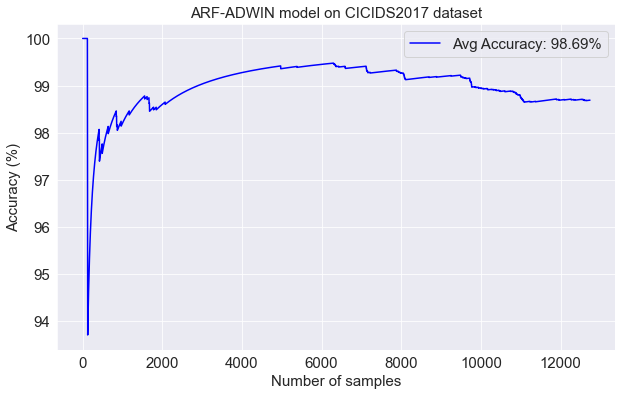

In [9]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 2. Dynamic Data Pre-Processing

The dynamic data pre-processing part focuses on data balancing and data normalization. Examples of using them are given below.   
* Data balancing methods include Dynamic Random Under-Sampling (DRUS) and Dynamic Random Over-Sampling (DROS);  
* Data normalization methods include dynamic min-max and Z-score scalers.  <br>


Change detected at index 1712
Change detected at index 6624
Change detected at index 7963
Change detected at index 9716
Change detected at index 10904
Change detected at index 11064
Accuracy: 97.66%
Precision: 91.13%
Recall: 95.04%
F1-score: 93.05%
Wall time: 9.15 s


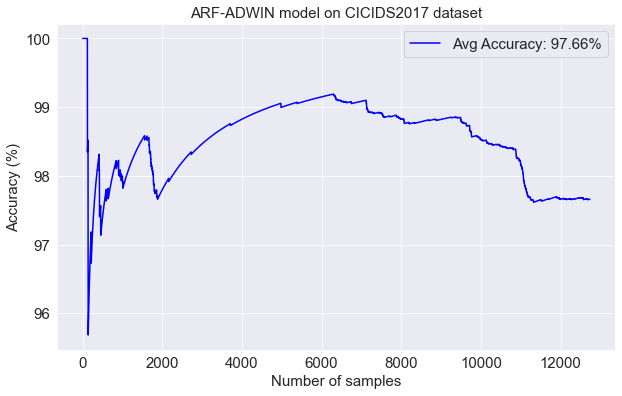

In [10]:
%%time
# Min-max normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 2071
Change detected at index 7142
Change detected at index 8064
Change detected at index 9686
Change detected at index 10173
Change detected at index 10636
Change detected at index 10933
Change detected at index 11091
Accuracy: 97.50999999999999%
Precision: 89.21%
Recall: 96.57%
F1-score: 92.74%
Wall time: 10.4 s


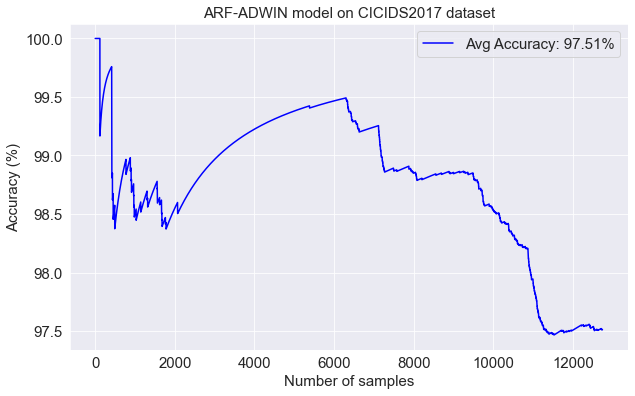

In [11]:
%%time
# Z-score normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 6403
Change detected at index 8056
Change detected at index 10158
Change detected at index 10893
Accuracy: 98.74000000000001%
Precision: 95.19999999999999%
Recall: 97.28%
F1-score: 96.23%
Wall time: 24.5 s


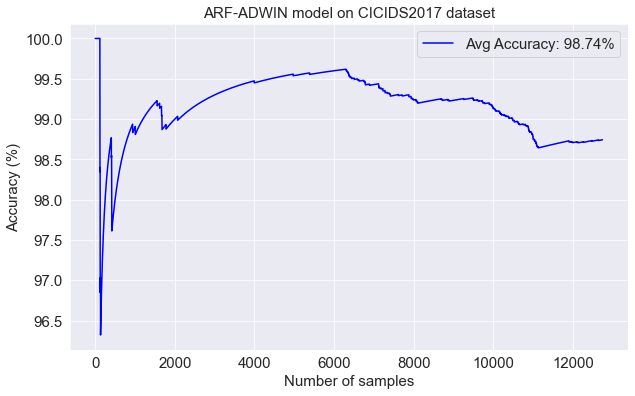

In [12]:
%%time
# Min-max normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 926
Change detected at index 6369
Change detected at index 7403
Change detected at index 9629
Change detected at index 11023
Accuracy: 98.32%
Precision: 93.13%
Recall: 96.95%
F1-score: 95.0%
Wall time: 27 s


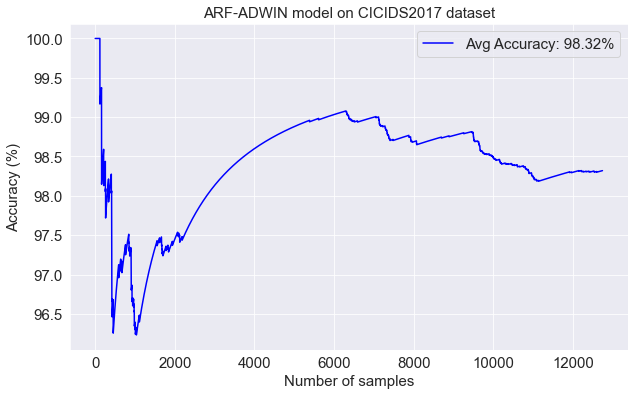

In [14]:
%%time
# Z-score normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 3. Model Learning

## Base Model Learning for Comparison Purposes
State-of-the-art online learning models:
* Adaptive Random Forest (ARF) with ADWIN drift detector
* Adaptive Random Forest (ARF) with EDDM drift detector
* Streaming Random Patches (SRP)
* Extremely Fast Decision Tree (EFDT)
* K-Nearest Neighbors (KNN) classifier with ADWIN change detector (KNN-ADWIN)
* Self Adapting Memory (SAM) KNN model (SAM-KNN)
* Online Passive-Aggressive (OPA)
* Leveraging Bagging (LB)
* Performance Weighted Probability Averaging Ensemble (PWPAE)
  * Proposed in the previous work
* Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)
  * Proposed

Change detected at index 7117
Change detected at index 8072
Change detected at index 9741
Change detected at index 10995
Change detected at index 12216
Accuracy: 98.5%
Precision: 96.53%
Recall: 94.28%
F1-score: 95.39%
Wall time: 16.9 s


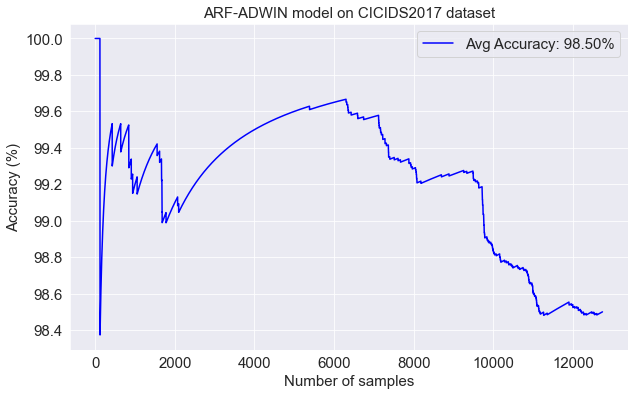

In [15]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 4980
Change detected at index 7878
Change detected at index 9635
Change detected at index 10911
Change detected at index 12541
Accuracy: 98.67%
Precision: 96.8%
Recall: 95.04%
F1-score: 95.91%
Wall time: 14.1 s


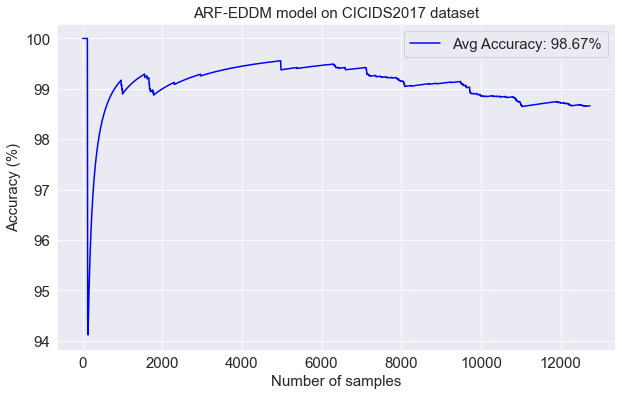

In [16]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name2 = "ARF-EDDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 4978
Change detected at index 7279
Change detected at index 9547
Change detected at index 11151
Accuracy: 98.72999999999999%
Precision: 97.17%
Recall: 95.04%
F1-score: 96.1%
Wall time: 1min 27s


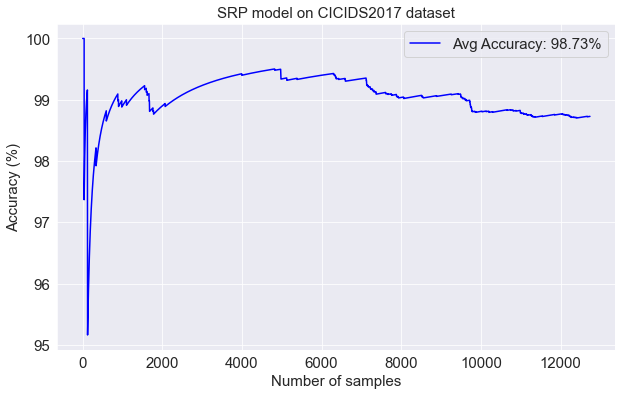

In [17]:
%%time
# Use the Streaming Random Patches (SRP) model
name3 = "SRP model"
model3 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 1169
Change detected at index 1609
Change detected at index 2157
Change detected at index 7143
Change detected at index 7366
Change detected at index 9495
Change detected at index 9740
Change detected at index 9948
Change detected at index 10093
Change detected at index 10229
Change detected at index 10337
Change detected at index 10433
Change detected at index 10897
Change detected at index 11237
Accuracy: 95.42%
Precision: 87.66000000000001%
Recall: 83.98%
F1-score: 85.78%
Wall time: 8.48 s


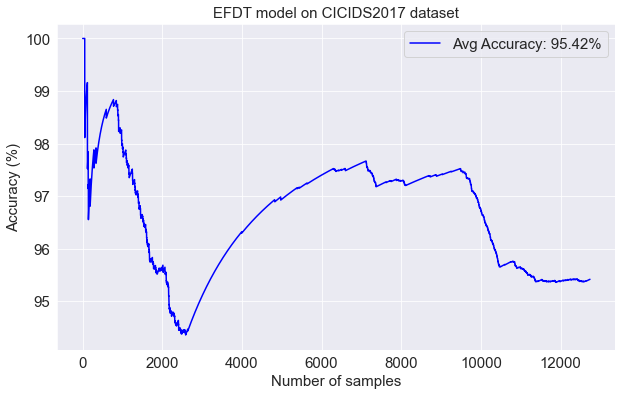

In [18]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name4 = "EFDT model"
model4 = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 966
Change detected at index 7220
Change detected at index 9686
Change detected at index 10915
Accuracy: 98.57000000000001%
Precision: 94.6%
Recall: 96.85000000000001%
F1-score: 95.71%
Wall time: 8.79 s


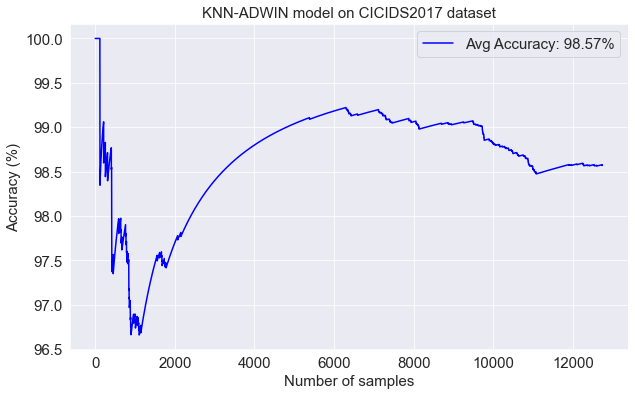

In [19]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name5 = "KNN-ADWIN model"
model5 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 903
Change detected at index 7148
Change detected at index 9716
Change detected at index 10885
Change detected at index 12729
Accuracy: 98.42999999999999%
Precision: 94.06%
Recall: 96.57%
F1-score: 95.3%
Wall time: 21.9 s


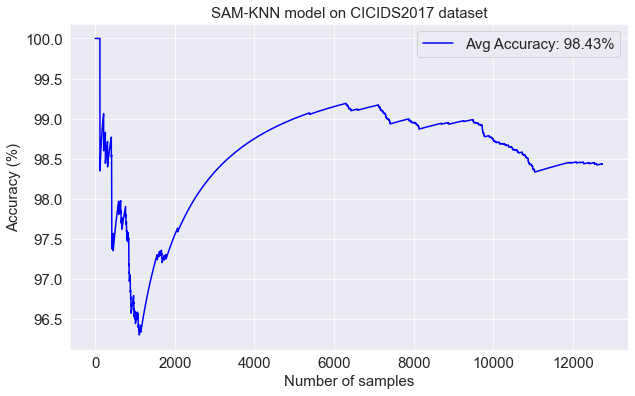

In [20]:
%%time
# Use the Self Adapting Memory (SAM) KNN model 
name6 = "SAM-KNN model"
model6 = neighbors.SAMKNNClassifier(window_size=100) # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 6588
Change detected at index 8024
Change detected at index 9634
Change detected at index 10881
Accuracy: 98.56%
Precision: 95.44%
Recall: 95.81%
F1-score: 95.62%
Wall time: 2.01 s


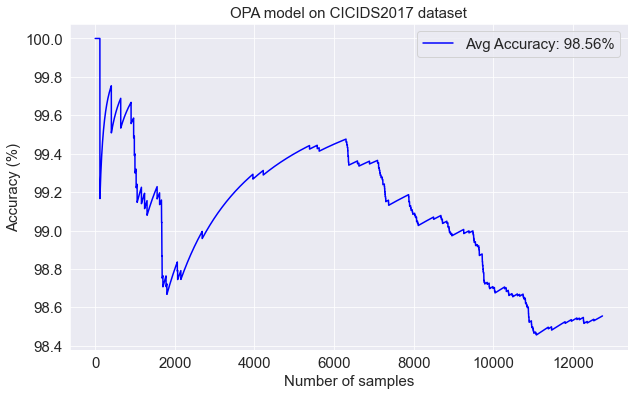

In [21]:
%%time
# Use the Online Passive-Aggressive (OPA) model
name7 = "OPA model"
model7 = linear_model.PAClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 4979
Change detected at index 7278
Change detected at index 9634
Change detected at index 10027
Change detected at index 10604
Change detected at index 10963
Accuracy: 98.3%
Precision: 94.26%
Recall: 95.47%
F1-score: 94.86%
Wall time: 2min 6s


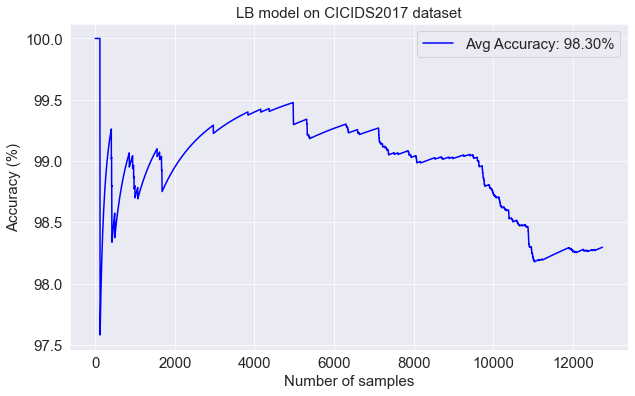

In [22]:
%%time
# Use the Leveraging Bagging (LB) model 
name8 = "LB model"
model8 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m8 = adaptive_learning(model8, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m8, name8) # Draw the figure of how the real-time accuracy changes with the number of samples

In [23]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
# proposed in our previous work: https://github.com/Western-OC2-Lab/PWPAE-Concept-Drift-Detection-and-Adaptation
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=2) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=2,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=15)
    # Initial FS
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 98.83999999999999%
Precision: 97.38%
Recall: 95.52000000000001%
F1-score: 96.44%
Wall time: 1min 7s


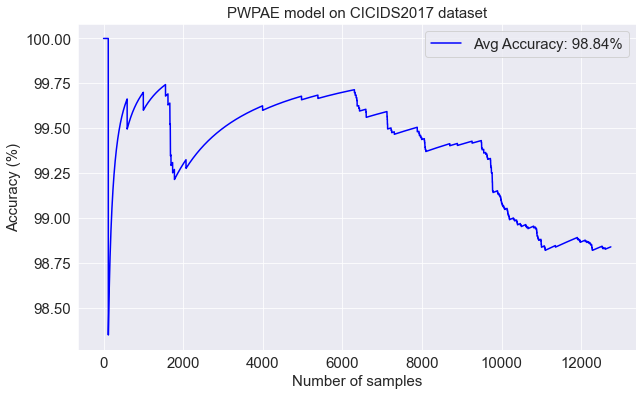

In [24]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name9 = "PWPAE model"
t, m9 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m9, name9) # Draw the figure of how the real-time accuracy changes with the number of samples

# 4. Proposed Multi-Stage Automated Network Analytics (MSANA) Framework
Main Module 1: Drift-based Dynamic Feature Selection  
Main Module 2: Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)

In [25]:
# Define the Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE) model
# An extension method of the PWPAE model
def MSANA(model1, model2, model3, model4, X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()
    
    metric_w1 = []
    metric_w2 = []
    metric_w3 = []
    metric_w4 = []


    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = model1
    hat2 = model2
    hat3 = model3
    hat4 = model4
    
    # Define the two feature selections methods: Variance Threshold and Select-K-Best
    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
    
    # Use EDDM to detect concept drift, it can be replaced with other drift detection methods like ADWIN, DDM, etc.
    eddm = EDDM()
    drift = 0

    # Initial feature selection on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Train the online models on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learners predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        if y_pred1 == yi:
            metric_w1.append(0)
        else:
            metric_w1.append(1)
        if y_pred2 == yi:
            metric_w2.append(0)
        else:
            metric_w2.append(1)
        if y_pred3 == yi:
            metric_w3.append(0)
        else:
            metric_w3.append(1)
        if y_pred4 == yi:
            metric_w4.append(0)
        else:
            metric_w4.append(1)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        
        # Calculate the real-time window error rates of four base learners
        if i<1000:
            e1 = 0
            e2 = 0
            e3 = 0
            e4 = 0
        else:        
            e1 = sum(metric_w1[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e2 = sum(metric_w2[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e3 = sum(metric_w3[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e4 = sum(metric_w4[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        
        # Calculate the weight of each base learner by the reciprocal of its window real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41
        
#         print(str(i)+" "+str(w1)+" "+str(w2)+" "+str(w3)+" "+str(w4)+" "+str(y_prob_0)+" "+str(y_prob_1))

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)
        
        # Detect concept drift
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        
        if in_drift & (i>1000) :
            print(f"Change detected at index {i}")
            drift = 1 # indicating that a drift occurs
        
        # If a drift is detected
        if drift == 1: 
            x_new = X_test[round(0.9*i):i]
            y_new = y_test[round(0.9*i):i]
            
            # Relearn the online models on the most recent window data (representing new concept data)
            hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            hat2 = neighbors.KNNADWINClassifier(window_size=100)
            hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            hat4 = linear_model.PAClassifier() # SRP-DDM
            
            # Re-select features
            selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
            selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
            
            for xj, yj in stream.iter_pandas(x_new, y_new):
                selector1 = selector1.learn_one(xj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                selector2 = selector2.learn_one(xj, yj)      
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                xa = selector2.transform_one(xj)
                hat1.learn_one(xa,yj)
                hat2.learn_one(xa,yj)
                hat3.learn_one(xa,yj)
                hat4.learn_one(xa,yj)
                
                if j ==1:
                    print(len(xa))
                    j=0
            drift = 0   
        
        j=1
        

        t.append(i)
        m.append(metric.get()*100)
        
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    
    # outputs
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    print(metric1.get()*100)
    print(metric2.get()*100)
    print(metric3.get()*100)
    print(metric4.get()*100)
    return t, m

Change detected at index 7224
40
Change detected at index 9723
40
Change detected at index 10961
40
Accuracy: 99.11%
Precision: 97.83%
Recall: 96.71%
F1-score: 97.27%
98.43014128728414
98.67346938775509
98.43014128728414
98.39874411302982
Wall time: 47.7 s


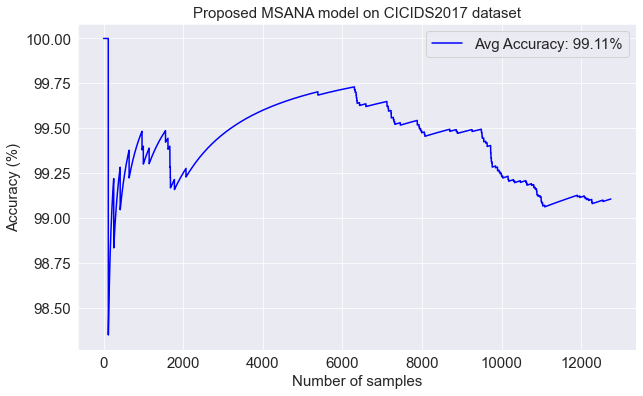

In [26]:
%%time
# Use the proposed Multi-Stage Automated Network Analytics (MSANA) model 

# Select the four base online models, they can be changed based on the performance of the models
bm1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
bm2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
bm3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
bm4 = linear_model.PAClassifier() # OPA

name = "Proposed MSANA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

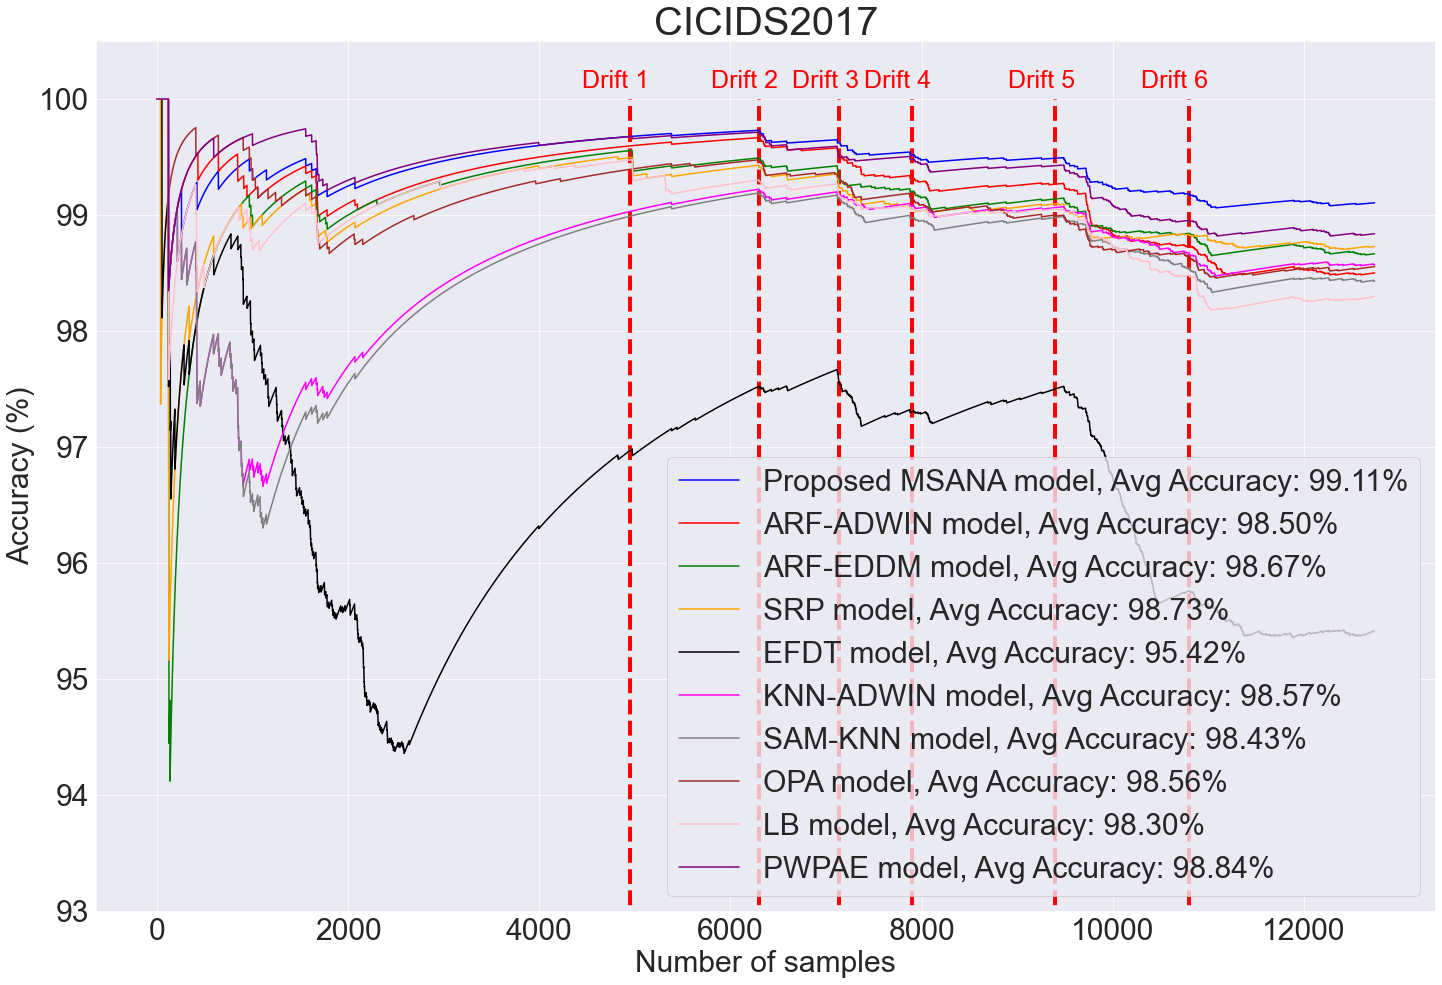

In [40]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,4950,6300, 7140,7900,9400,10800]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.1, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(93, 100.5)
plt.title('CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

The performance of the proposed MSANA model outperforms other models. Please note that the results might be different when using different datasets or different subsets of the CICIDS2017 dataset.

Change detected at index 7148
40
Change detected at index 9739
40
Change detected at index 10974
40
Accuracy: 99.11%
Precision: 97.6%
Recall: 96.95%
F1-score: 97.27%
98.19466248037678
98.55572998430141
98.64207221350078
98.34379905808477
Wall time: 49.8 s


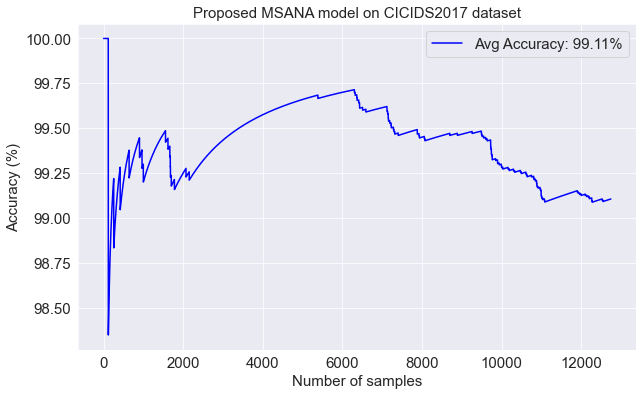

In [45]:
%%time
# Example: combine the ensemble model with dynamic data balancing methods.

bm1 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3),
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm2 = imblearn.RandomOverSampler(neighbors.KNNADWINClassifier(window_size=100),
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm3 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()), # ARF-EDDM,
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm4 = imblearn.RandomOverSampler(linear_model.PAClassifier(), # SRP-DDM
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN

name = "Proposed MSANA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

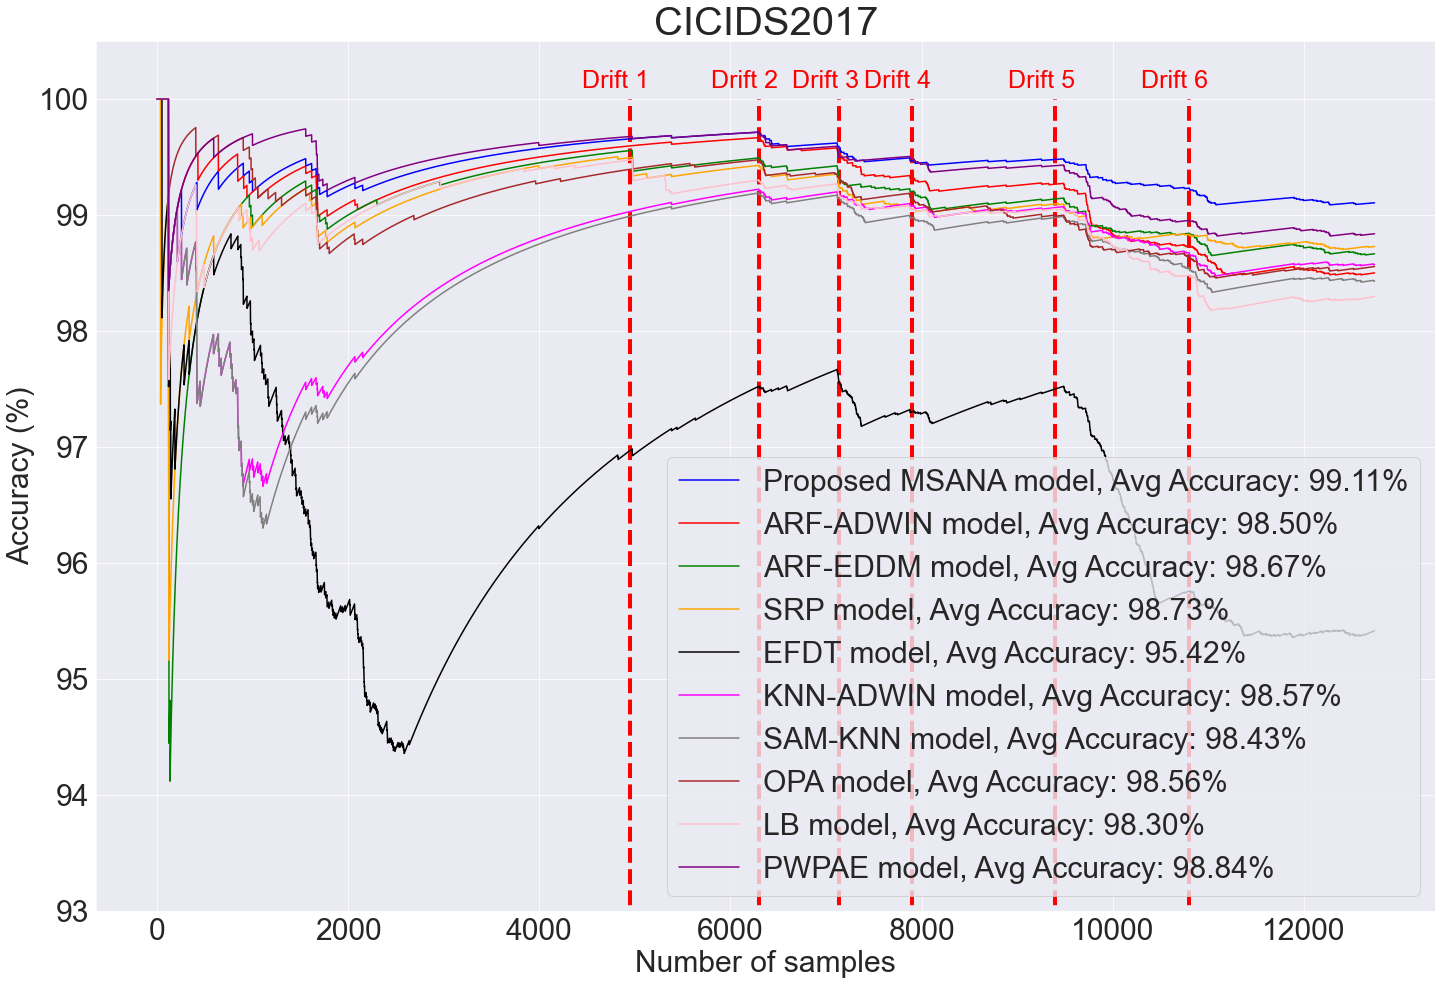

In [46]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,4950,6300, 7140,7900,9400,10800]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.1, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(93, 100.5)
plt.title('CICIDS2017', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()